In [1]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import obspy
import datetime
import os
import glob

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
# Define the path to store all the output results
output_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [3]:
# load the DAS channel location
DAS_info = np.genfromtxt('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Ridgecrest_ODH3.txt')

DAS_channel_num = DAS_info.shape[0]
DAS_index = DAS_info[:, 0].astype('int')
DAS_lon = DAS_info[:, 1]
DAS_lat = DAS_info[:, 2]

Import the data, tried a few events

In [4]:
catalog_file = '/home/yinjx/notebooks/strain_scaling/Ridgecrest_das_catalog_M2_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
catalog_select = catalog[(catalog[7] >= 4.6) & (catalog[6] > 1)] # choose the event with magnitude > 5

eq_num = catalog_select.shape[0]
eq_id = np.array(catalog_select[0])
eq_time = np.array(catalog_select[3])
eq_lat = np.array(catalog_select[4])
eq_lon = np.array(catalog_select[5])
eq_dep = np.array(catalog_select[6])
eq_mag = np.array(catalog_select[7])

print(f'Total number of events: {eq_num}')
catalog_select

Total number of events: 8


,0,1,2,3,4,5,6,7,8,9
374,38548295,eq,l,"2019/07/12,13:11:37.990",35.6368,-117.5862,9.48,4.90,w,1.0
944,38593535,eq,l,"2019/07/18,03:59:14.720",36.1130,-117.8875,1.56,4.64,w,1.0
1345,38644943,eq,l,"2019/07/26,00:42:47.770",35.9258,-117.7067,3.79,4.74,w,1.0
1956,38996632,eq,l,"2019/08/22,20:49:50.180",35.9077,-117.7090,4.93,4.89,w,1.0
2888,39281440,eq,l,"2020/01/25,03:03:34.920",35.0975,-116.9697,3.07,4.62,w,1.0
3287,39462536,eq,l,"2020/06/04,01:32:11.140",35.6148,-117.4282,8.44,5.51,w,1.0
3396,39490952,eq,l,"2020/06/23,00:25:46.390",36.4467,-117.9840,2.26,4.65,w,1.0
3425,39493944,eq,l,"2020/06/24,17:40:49.240",36.4468,-117.9752,4.66,5.80,w,1.0


In [5]:
event_id_test_all = catalog_select[0]
event_id_test_all

374     38548295
944     38593535
1345    38644943
1956    38996632
2888    39281440
3287    39462536
3396    39490952
3425    39493944
Name: 0, dtype: int64

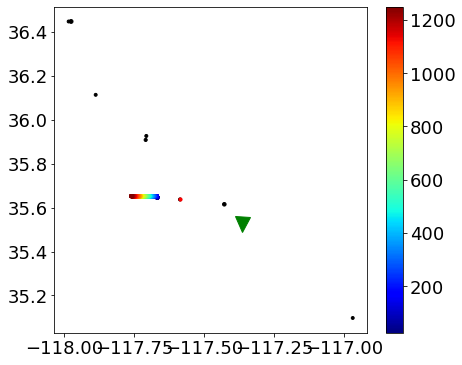

In [33]:
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(eq_lon, eq_lat, s=10**(eq_mag/5), c='k')
ii_eq = event_id_test_all == 38548295
ax.scatter(eq_lon[ii_eq], eq_lat[ii_eq], s=10**(eq_mag[ii_eq]/5), c='r')

AZ_BZN = [-116.667, 33.4915]
CI_CCC = [-117.3645, 35.5249]
ax.plot(CI_CCC[0], CI_CCC[1], 'gv', markersize=15)
fig.colorbar(cmp)

In [8]:
from scipy.interpolate import interp1d

def extrapolate_arrival_time(ml_picks, kind='linear'):
    channel = np.array(ml_picks['station_name'])
    phase_index = np.array(ml_picks['phase_index'])
    channel_all = np.arange(0, DAS_channel_num)
    if kind is None:
        phase_index_extrap = np.ones(channel_all.shape) * -1
        phase_index_extrap[channel] = phase_index
        
    else:
        interp_f = interp1d(channel, phase_index, kind=kind, fill_value='extrapolate')
        phase_index_extrap = interp_f(channel_all).astype('int')
    
    return phase_index_extrap

def std_filter(arrival_time, factor=10, fill_value=np.nan):
    mean_arrival, std_arrival = np.nanmean(arrival_time), np.nanstd(arrival_time)
    arrival_time[abs(arrival_time - mean_arrival) > factor * std_arrival] = fill_value
    return arrival_time
    
def median_filter(arrival_time, difference=10, fill_value=np.nan):
    median_arrival = np.nanmedian(arrival_time)
    arrival_time[abs(arrival_time - median_arrival) > difference] = fill_value
    return arrival_time

Event 38548295 done!


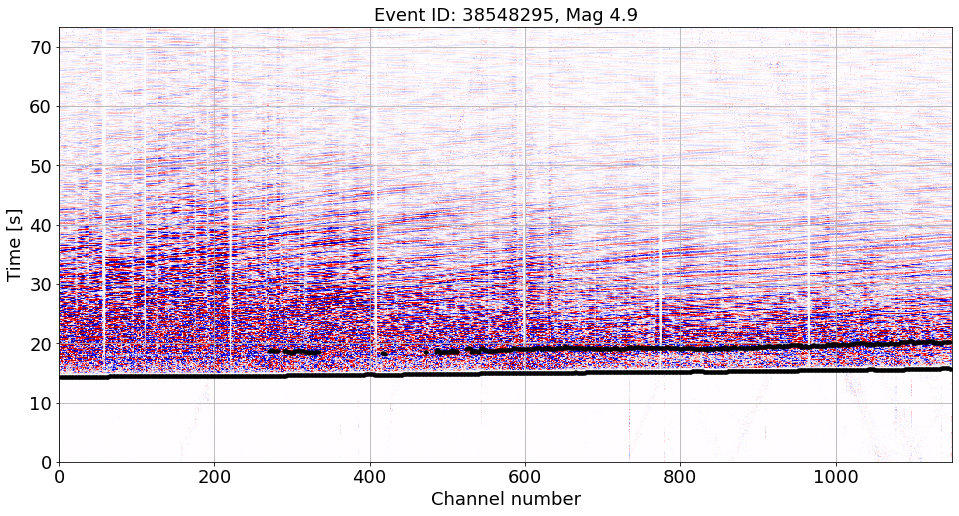

In [24]:
extrapolate_ml_picking = False

# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
test_event_id = 38548295 #39493944 #39462536
for eq_id_current in [test_event_id]:#eq_id:
    event_test = catalog[catalog[0] == eq_id_current]
    event_lon, event_lat = event_test[5], event_test[4]
    event_mag = event_test[7]

    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
            fig_name = f'{eq_id_current}_ml_extrap_nearest.png'
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            fig_name = f'{eq_id_current}_ml.png'
        
    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0], allow_pickle=True)
        data_diff = temp[temp.files[0]]
        eq_t0 = temp[temp.files[1]]
        das_time_t0 = temp[temp.files[2]]
        
        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        # Slight modify only for plotting purpose
        event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
        event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

        # Filter out some obvious outliers based on STD
        event_arrival_P_ml = std_filter(event_arrival_P_ml)
        event_arrival_S_ml = std_filter(event_arrival_S_ml)

        # Filter out some obvious outliers based on median
        event_arrival_P_ml = median_filter(event_arrival_P_ml)
        event_arrival_S_ml = median_filter(event_arrival_S_ml)

        # Show data
        fig, ax1 = plt.subplots(figsize=(16,8))
        pclip=99.9
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        # Vx
        ax1.imshow(data_diff, 
                    extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        ax1.plot(event_arrival_P_ml, '.k', linewidth=2, zorder=10)
        ax1.plot(event_arrival_S_ml, '.k', linewidth=2, zorder=10)
        
        ax1.set_title(f'Event ID: {eq_id_current}, Mag {event_mag.values[0]:.1f}')
        ax1.set_xlabel("Channel number")
        ax1.set_ylabel("Time [s]")
        ax1.grid()
        #ax1.set_ylim(10, 12)
        ax1.invert_yaxis()

        # plt.savefig(das_path + '/' + fig_name)
        # plt.close('all')
        print(f'Event {eq_id_current} done!')
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

In [13]:
eq_t0

array(UTCDateTime(2019, 7, 12, 13, 11, 37, 990000), dtype=object)

In [14]:
das_time_t0

array(UTCDateTime(2019, 7, 12, 13, 11, 29, 538792), dtype=object)

### Now assume that we have detected events and begin to use its arrival time curves to locate earthquake

In [15]:
# Load the calculated templates
temp = np.load('/kuafu/yinjx/Ridgecrest/arrival_time_matching/arrival_time_template.npz')
distance_to_source_all = temp['distance_grid']
lat_grid = temp['lat_grid']
lon_grid = temp['lon_grid']
event_arrival_P_template = temp['event_arrival_P']
event_arrival_S_template = temp['event_arrival_S']

In [16]:
def match_arrival(event_arrival_observed, event_arrival_template, misfit_type='l1'):
    ii_nan = np.isnan(event_arrival_observed)
    event_arrival = event_arrival_observed[~ii_nan, np.newaxis]
    template = event_arrival_template[~ii_nan, :]

    # remove mean
    event_arrival = event_arrival - np.mean(event_arrival, axis=0, keepdims=True)
    template = template - np.mean(template, axis=0, keepdims=True)
    
    if misfit_type == 'l1':
        norm_diff = np.mean(abs(event_arrival - template), axis=0) # L1 norm
    elif misfit_type == 'l2':
        norm_diff = np.sqrt(np.mean((event_arrival - template)**2, axis=0)) # L2 norm
        
    ii_min = np.argmin(norm_diff)

    return ii_min, norm_diff

def misfit_to_probability(misfit):
    sigma_misfit = np.std(misfit)
    probability = np.exp(-misfit**2/2/sigma_misfit**2)/sigma_misfit/np.sqrt(2*np.pi)
    probability = probability/np.sum(probability)

    return probability
    

## Test locating with matching arrival time curves

In [17]:
# Define the path to store all the output results
figure_output_dir = output_dir + f'/{test_event_id}'
if not os.path.exists(figure_output_dir):
    os.mkdir(figure_output_dir)

In [18]:
# Assume this is when the earthquake was detected
starting_time = np.nanmin(event_arrival_P_ml)

In [27]:
distance_to_station = 23.56/111.3

In [31]:
# 0.25 s after starting time
def arrival_time_locating(time_after_detection, event_arrival_P_ml, event_arrival_P_template):

    event_arrival_P_obtained = event_arrival_P_ml.copy()
    ii_time = (event_arrival_P_obtained >= starting_time) & (event_arrival_P_obtained < starting_time + time_after_detection)
    event_arrival_P_obtained[~ii_time] = np.nan

    ii_min, norm_diff = match_arrival(event_arrival_P_obtained, event_arrival_P_template, misfit_type='l2')
    probability = misfit_to_probability(norm_diff)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(8, 14), gridspec_kw={'height_ratios': [1, 3]})

    gca = ax[0]
    gca.plot(event_arrival_P_ml, '.k')
    gca.plot(event_arrival_P_obtained, 'r.')
    gca.invert_yaxis()
    gca.set_ylabel('Time')
    gca.set_xlabel('Channels')
    gca.set_title(f'{time_after_detection:.2f} s after detection')

    gca = ax[1]
    cmp = gca.scatter(DAS_lon, DAS_lat, s=1, c='b')
    gca.plot(lon_grid.flatten(), lat_grid.flatten(), 'k+')
    gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'x', markersize=20, color='gold')
    gca.plot(event_lon, event_lat, 'r*', markersize=20)
    gca.plot(CI_CCC[0], CI_CCC[1], 'gv', markersize=15)
    dist_circle = plt.Circle((CI_CCC[0], CI_CCC[1]), distance_to_station, fill = False, zorder=10)
    gca.add_artist(dist_circle)
    
    # gca.set_ylim(center_lat-1.1, center_lat+1.1)
    # gca.set_xlim(center_lon-1.1, center_lon+1.1)

    cbar = gca.scatter(lon_grid, lat_grid, s=800, c= np.reshape(probability, lon_grid.shape), cmap='gray', marker='s')
    gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'yx', markersize=20, markeredgewidth=5)
    # gca.plot(event_test[5], event_test[4], 'r*', markersize=20)
    gca.set_title('P location')
    fig.colorbar(cbar, ax=gca, label='probability')

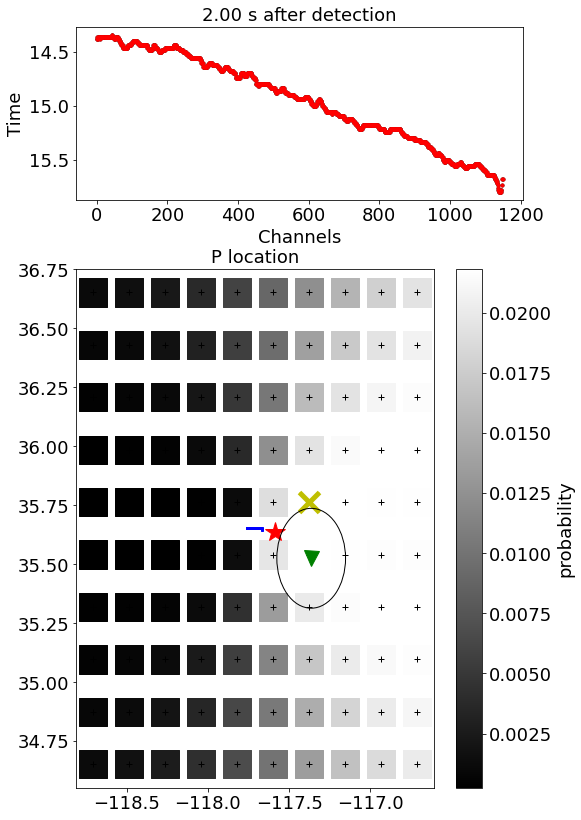

In [32]:
# 0.25 s after starting time
time_after_detection = 0.5
for time_after_detection in [2]:#np.arange(0.1, 2, 0.1):
    arrival_time_locating(time_after_detection, event_arrival_P_ml, event_arrival_P_template)
    # plt.savefig(figure_output_dir + f'/{time_after_detection:.1f}s_locating.png', bbox_inches='tight')
    # plt.close('all')

## Test magnitude estimation using the location estimation from above steps

In [14]:
pclip=90
clipVal = np.percentile(np.absolute(data_diff), pclip)

In [15]:
# Prepare the magnitude estimation parameters
import statsmodels.api as sm

#%% load the results from combined regional site terms t
results_output_dir = '/home/yinjx/kuafu/Ridgecrest/Ridgecrest_scaling/peak_amplitude_scaling_results_strain_rate'#'/kuafu/yinjx/multi_array_combined_scaling/combined_strain_scaling_RO'
regression_dir = 'regression_results_smf'
site_term_column = 'region_site'
nearby_channel_number = 10

# load regression parameters
regP = sm.load(results_output_dir + '/' + regression_dir + f"/P_regression_combined_site_terms_{nearby_channel_number}chan.pickle")
#regS = sm.load(results_output_dir + '/' + regression_dir + f"/S_regression_combined_site_terms_{nearby_channel_number}chan.pickle")

temp2 = DAS_index // nearby_channel_number # combined channel number
site_term_keys = np.array([f'C(combined_channel_id)[{site_term}]' for site_term in temp2])
site_terms = np.array(regP.params[site_term_keys])
site_terms = site_terms[np.newaxis, :]

In [82]:
event_id_test_all

374     38548295
944     38593535
1345    38644943
1956    38996632
2888    39281440
3287    39462536
3396    39490952
3425    39493944
Name: 0, dtype: int64

In [19]:
for test_event_id in event_id_test_all:
    print(test_event_id)
    # Define the path to store all the output results
    figure_output_dir = output_dir + f'/{test_event_id}'
    if not os.path.exists(figure_output_dir):
        os.mkdir(figure_output_dir)

    event_test = catalog[catalog[0] == test_event_id]
    event_lon, event_lat = event_test[5], event_test[4]
    event_mag = event_test[7]

    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{test_event_id}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            
    except:
        print(f'ML picking {test_event_id} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{test_event_id}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]

        pclip=90
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        
        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        # Slight modify only for plotting purpose
        event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
        event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

        # Filter out some obvious outliers based on STD
        event_arrival_P_ml = std_filter(event_arrival_P_ml)
        event_arrival_S_ml = std_filter(event_arrival_S_ml)

        # Filter out some obvious outliers based on median
        event_arrival_P_ml = median_filter(event_arrival_P_ml)
        event_arrival_S_ml = median_filter(event_arrival_S_ml)
    except:
        continue

    starting_time = np.nanmin(event_arrival_P_ml)
    # Making figures
    for time_after_detection in np.arange(0.5, 10.5, 0.5):
        # Match location of earthquakes
        event_arrival_P_obtained = event_arrival_P_ml.copy()
        ii_time = (event_arrival_P_obtained >= starting_time) & (event_arrival_P_obtained <= starting_time + time_after_detection)
        event_arrival_P_obtained[~ii_time] = np.nan

        ii_min, norm_diff = match_arrival(event_arrival_P_obtained, event_arrival_P_template, misfit_type='l2')
        probability = misfit_to_probability(norm_diff)

        # Estimate magnitude
        distance_to_source_all_0 = distance_to_source_all * 113
        distance_to_source = distance_to_source_all_0[:, ii_min] 

        ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
        data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)

        mag_estimate = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']
        mag_estimate_all = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source_all_0.T)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']
        mag_estimate_median = np.nanmedian(mag_estimate_all, axis=1)

        # combine location probability with the magnitude
        combined_mean = np.sum(mag_estimate_median * probability)

        # Plotting
        fig, ax = plt.subplots(2, 1, figsize=(10, 15), gridspec_kw={'height_ratios': [1, 3]})

        gca = ax[0]

        gca.imshow(data_diff[ii_time_array, :], 
                    extent=[0, data_diff.shape[1], das_time[ii_time_array][-1], das_time[ii_time_array][0]],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        gca.plot(event_arrival_P_ml, '.k')
        gca.plot(event_arrival_P_obtained, 'r.')
        gca.plot(event_arrival_S_ml, '.k')
        gca.set_ylim(starting_time - 0.5, starting_time + 10)
        gca.invert_yaxis()
        gca.set_ylabel('Time')
        gca.set_xlabel('Channels')
        gca.set_title(f'{time_after_detection} s after detection')

        gca = ax[1]
        cmp = gca.scatter(DAS_lon, DAS_lat, s=2, c='b')
        gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'x', markersize=25, color='gold')
        gca.plot(event_lon, event_lat, 'r*', markersize=10)
        # gca.set_ylim(center_lat-1.1, center_lat+1.1)
        # gca.set_xlim(center_lon-1.1, center_lon+1.1)

        cbar = gca.scatter(lon_grid, lat_grid, s=1200, c= np.reshape(probability, lon_grid.shape), cmap='hot', marker='s', alpha=0.5)
        gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'yx', markersize=20, markeredgewidth=5)

        # for i_grid in range(len(mag_estimate_median)):
        #     gca.text(lon_grid.flatten()[i_grid], lat_grid.flatten()[i_grid], f'{mag_estimate_median[i_grid]:.1f}', 
        #     color='orange', fontsize=15, ha='center', va='center')
        CS = gca.contour(lon_grid, lat_grid, np.reshape(mag_estimate_median, lon_grid.shape), linewidths=3, 
                        levels=np.arange(1, 10, 0.5), cmap='brg')
        gca.clabel(CS, CS.levels, inline=True, fontsize=15)

        gca.text(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], f'{mag_estimate_median[ii_min]:.1f}', 
        color='red', fontsize=25, ha='center', va='center')

        gca.set_aspect('equal')
        gca.set_title(f'ID: {test_event_id}, M {event_mag.values[0]:.1f}')
        gca.set_xticks(np.arange(-119, -116, 0.5))

        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(gca)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(cbar, cax=cax, label='pdf',ticks=np.arange(0.01, 1.1, 0.01))

        plt.savefig(figure_output_dir + f'/{time_after_detection}s_prediction.png', bbox_inches='tight')
        plt.close('all')


38548295
38593535
38644943
38996632
39281440
39462536
39490952
39493944


In [91]:
figure_output_dir

'/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440'

In [25]:
import os
import moviepy.video.io.ImageSequenceClip
for test_event_id in event_id_test_all:
    print(test_event_id)
    image_folder = output_dir + f'/{test_event_id}'

    fps=2

    image_files = []
    for time_after_detection in np.arange(0.5, 10.5, 0.5):
        image_files.append(image_folder + f'/{time_after_detection}s_prediction.png')

    # image_files = [os.path.join(image_folder,img)
    #                for img in os.listdir(image_folder)
    #                if img.endswith(".png")]
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(image_folder + f'/{test_event_id}.mp4')
    clip.write_gif(image_folder + f'/{test_event_id}.gif')

38548295
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38548295/38548295.gif with imageio.


38593535
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38593535/38593535.gif with imageio.


38644943
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38644943/38644943.gif with imageio.


38996632
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/38996632/38996632.gif with imageio.


39281440
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39281440/39281440.gif with imageio.


39462536
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39462536/39462536.gif with imageio.


39490952
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39490952/39490952.gif with imageio.


39493944
Moviepy - Building video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.mp4.
Moviepy - Writing video /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.mp4



Moviepy - Done !
Moviepy - video ready /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.mp4
MoviePy - Building file /kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/EEW_tests/39493944/39493944.gif with imageio.


In [88]:
ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)


In [96]:
distance_to_source = distance_to_source_all[:, ii_min] * 113

ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)

mag_estimate = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']


In [105]:
distance_to_source = distance_to_source_all * 113

ii_time_array = (das_time >= starting_time) & (das_time < starting_time + time_after_detection)
data_peak_mat = np.nanmax(data_diff[ii_time_array, :], axis=0)

mag_estimate = (np.log10(data_peak_mat+1e-12) - site_terms - np.log10(distance_to_source.T)*regP.params['np.log10(distance_in_km)'])/regP.params['magnitude']


In [106]:
mag_estimate.shape

(100, 1150)

In [107]:
mag_estimate_median = np.nanmedian(mag_estimate, axis=1)

In [108]:
mag_estimate_median

array([ 5.60730987,  5.51803787,  5.43827742,  5.37926618,  5.34438063,
        5.34338571,  5.37518874,  5.43559087,  5.51403992,  5.60251934,
        5.46800936,  5.34790752,  5.23401957,  5.14073571,  5.08800744,
        5.08613179,  5.13834701,  5.22678155,  5.34007706,  5.45993235,
        5.3309754 ,  5.1686372 ,  5.00067695,  4.84756399,  4.74747465,
        4.74328705,  4.83705477,  4.98541001,  5.15297473,  5.3170342 ,
        5.211554  ,  4.99713316,  4.74755253,  4.47066877,  4.24463502,
        4.23460162,  4.45029313,  4.72770733,  4.97884727,  5.19419518,
        5.13916844,  4.88679624,  4.55429604,  4.07753615,  3.34632008,
        3.30060164,  4.04424185,  4.5267168 ,  4.86403579,  5.12206351,
        5.13759116,  4.88558882,  4.55262841,  4.07661991,  3.34537499,
        3.30442905,  4.04429936,  4.52550322,  4.86249161,  5.12051761,
        5.207473  ,  4.99414372,  4.74620819,  4.47041797,  4.24473976,
        4.23481642,  4.44811681,  4.72459785,  4.97718516,  5.19

In [1]:
fig, ax = plt.subplots(figsize=(10, 10))
gca = ax
cmp = gca.scatter(DAS_lon, DAS_lat, s=1, c='b')
gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'x', markersize=20, color='gold')
gca.plot(event_lon, event_lat, 'r*', markersize=20)
# gca.set_ylim(center_lat-1.1, center_lat+1.1)
# gca.set_xlim(center_lon-1.1, center_lon+1.1)

cbar = gca.scatter(lon_grid, lat_grid, s=800, c= np.reshape(np.exp(-norm_diff), lon_grid.shape), cmap='gray', marker='s')
gca.plot(lon_grid.flatten()[ii_min], lat_grid.flatten()[ii_min], 'yx', markersize=20, markeredgewidth=5)

for i_grid in range(len(mag_estimate_median)):
    gca.text(lon_grid.flatten()[i_grid], lat_grid.flatten()[i_grid], f'{mag_estimate_median[i_grid]:.1f}', 
    color='orange', fontsize=15, ha='center', va='center')
gca.contourf(lon_grid, lat_grid, mag_estimate_median)

# gca.plot(event_test[5], event_test[4], 'r*', markersize=20)
gca.set_title('P location')
fig.colorbar(cbar, ax=gca, label='probability')

NameError: name 'plt' is not defined

In [132]:
np.nansum(np.exp(-norm_diff).shape * mag_estimate_median)/ np.nansum(np.exp(-norm_diff).shape)/100

4.9658333663305463

In [131]:
np.exp(-norm_diff)

array([ 0.86754438,  0.88874115,  0.90580882,  0.90288213,  0.87272227,
        0.83236927,  0.7868311 ,  0.74631289,  0.71338212,  0.68860509,
        0.83933316,  0.8681501 ,  0.89487956,  0.90905769,  0.87791789,
        0.8263983 ,  0.76897388,  0.72237522,  0.68905647,  0.66637431,
        0.80736996,  0.83092095,  0.8690243 ,  0.90462933,  0.88680484,
        0.81519767,  0.74018937,  0.68968647,  0.66000604,  0.64229838,
        0.77716651,  0.78986085,  0.81515181,  0.87078817,  0.90385456,
        0.78934105,  0.69093672,  0.64814318,  0.62929976,  0.62004957,
        0.7573098 ,  0.75947496,  0.76447393,  0.78074713,  0.88320525,
        0.70069094,  0.6228742 ,  0.6112869 ,  0.60794723,  0.60659413,
        0.75623199,  0.75799031,  0.76227738,  0.77700735,  0.87571388,
        0.71112287,  0.62768397,  0.61433802,  0.61021527,  0.60842543,
        0.7742139 ,  0.78592282,  0.80970133,  0.86382546,  0.91669611,
        0.80457053,  0.70204545,  0.65639785,  0.63578689,  0.62

In [139]:
mag_estimate_median = np.nanmedian(mag_estimate, axis=1)